# Settings

In [17]:
# Since the project folder is called "crm-vip-data-scientist-take-home-challenge"
# Set this notebook to the project folder as working directory 

import os

current_working_dir = os.path.normpath(os.getcwd()).split(os.path.sep)[-1]

if current_working_dir != 'crm_project':
    os.chdir('..')

In [229]:
import pandas as pd
import sidetable

import seaborn as sns
import matplotlib.pyplot as plt

In [254]:
df_train = pd.read_csv('data/train_set.csv', index_col='mk_CurrentCustomer')

df_train.isna().any().any()

False

In [277]:
df_train = pd.read_csv('data/train_set.csv', index_col='mk_CurrentCustomer')
df_customer_country = pd.read_csv('data/customer_country.csv', index_col='mk_CurrentCustomer')

In [278]:
df_customer_country.to_parquet('data/customer_country.parquet')

In [279]:
pd.read_parquet('data/customer_country.parquet')

,country
mk_CurrentCustomer,
7343754,France
6210071,Italy
15837704,France
15235670,France
14755861,France
...,...
2625974,Germany
12454467,France
7831140,Germany


In [76]:
# Load datasets, specifying the customer IDs as index
df_train = pd.read_csv('data/train_set.csv', index_col='mk_CurrentCustomer')
df_customer_country = pd.read_csv('data/customer_country.csv', index_col='mk_CurrentCustomer')

# Convert date columns to date specifying the format (it's much faster when specifying it)
df_train['ScoreDate'] = pd.to_datetime(df_train['ScoreDate'], format='%d/%m/%Y %H:%M')

# Merging the datasets
# Note: Since there are no duplicated IDs (see next cells), it's safe to merge it here
df = df_train.join(df_customer_country, how='left')

# Show quantity of rows, columns, and first rows
print(df.shape)
display(df.head())

(55415, 270)


,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2019-08-29,2,0,2,3,3,3,2,5,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,2019-08-29,4,3,2,5,3,3,5,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,2019-08-29,4,1,2,4,7,4,1,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2019-08-29,2,3,7,4,1,2,0,2,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,2019-08-29,5,1,4,4,3,4,4,3,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy


# EDA

## Quality checks

In [77]:
# Checking duplicated customers on both files (that's how we know it's safe to merge them)
df_train.index.duplicated().any() | df_customer_country.index.duplicated().any()

False

In [78]:
# Checking if amount of rows from the train data remains
df_train.shape[0] == df.shape[0]

True

In [43]:
# Check missing values
df.isna().any().any()

False

In [79]:
# Check target proportion
df.stb.freq(['target'])

,target,count,percent,cumulative_count,cumulative_percent
0,0,54474,98.301904,54474,98.301904
1,1,941,1.698096,55415,100.000000


In [80]:
df

,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2019-08-29,2,0,2,3,3,3,2,5,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,2019-08-29,4,3,2,5,3,3,5,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,2019-08-29,4,1,2,4,7,4,1,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2019-08-29,2,3,7,4,1,2,0,2,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,2019-08-29,5,1,4,4,3,4,4,3,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831140,2019-08-29,0,5,2,0,0,1,3,0,2,...,1690,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Germany
11118841,2019-08-29,2,1,6,4,3,1,3,4,5,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
6332527,2019-08-29,4,2,2,7,3,3,3,3,7,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France


In [96]:
# Check columns with constant value (we'll remove them from analysis/modeling)
columns_with_constant = df.agg('nunique').eq(1)
columns_with_constant[columns_with_constant].index.tolist()

['ScoreDate']

In [99]:
df.loc[:,'days_g10':'days_since_last_SE_GI_wrt_std'].corr()

,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,days_g1,...,SE_GI_wrt_days_70days,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std
days_g10,1.000000,0.530455,0.443198,0.401873,0.392187,0.361366,0.333157,0.318389,0.317353,0.310968,...,-0.004328,0.033898,0.007936,0.005634,0.007627,0.007321,0.008708,0.011806,0.008266,0.000606
days_g9,0.530455,1.000000,0.600609,0.479880,0.422910,0.413942,0.384667,0.349378,0.334951,0.329037,...,-0.004001,0.036691,0.015020,0.007985,0.012302,0.014193,0.007218,0.013479,0.006660,-0.000736
days_g8,0.443198,0.600609,1.000000,0.619125,0.505641,0.465843,0.444731,0.408479,0.379623,0.361442,...,-0.005154,0.024237,0.004599,0.004740,0.005202,0.003589,0.001749,0.010408,0.001371,0.000369
days_g7,0.401873,0.479880,0.619125,1.000000,0.657863,0.553417,0.502346,0.485176,0.458544,0.407018,...,-0.004799,0.022722,-0.005307,-0.000090,-0.003325,-0.007010,-0.002063,0.008620,-0.001753,0.000254
days_g6,0.392187,0.422910,0.505641,0.657863,1.000000,0.669346,0.554213,0.503202,0.490843,0.455086,...,-0.004539,0.017869,-0.008583,-0.000098,-0.004769,-0.011080,0.000175,0.006994,0.000243,-0.000214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE_GI_std_datediff,0.007321,0.014193,0.003589,-0.007010,-0.011080,-0.011491,-0.014502,-0.017065,-0.019130,-0.019034,...,0.002762,0.138275,0.777656,0.153023,0.511004,1.000000,0.019398,0.156426,0.029051,0.016177
days_since_last_SE_GI_wrt_max,0.008708,0.007218,0.001749,-0.002063,0.000175,0.002442,0.004471,0.003378,0.006106,0.004793,...,0.000288,0.159405,0.033323,0.031254,0.035072,0.019398,1.000000,0.516934,0.985832,0.360303
days_since_last_SE_GI_wrt_min,0.011806,0.013479,0.010408,0.008620,0.006994,0.007684,0.012424,0.003573,0.007681,0.006214,...,0.000079,0.205520,0.139175,0.011489,0.071790,0.156426,0.516934,1.000000,0.583769,0.258934
days_since_last_SE_GI_wrt_avg,0.008266,0.006660,0.001371,-0.001753,0.000243,0.002476,0.004657,0.002716,0.005750,0.005113,...,0.000224,0.172057,0.040785,0.029805,0.037705,0.029051,0.985832,0.583769,1.000000,0.446196


In [102]:
df

,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2019-08-29,2,0,2,3,3,3,2,5,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,2019-08-29,4,3,2,5,3,3,5,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,2019-08-29,4,1,2,4,7,4,1,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2019-08-29,2,3,7,4,1,2,0,2,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,2019-08-29,5,1,4,4,3,4,4,3,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831140,2019-08-29,0,5,2,0,0,1,3,0,2,...,1690,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Germany
11118841,2019-08-29,2,1,6,4,3,1,3,4,5,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
6332527,2019-08-29,4,2,2,7,3,3,3,3,7,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France


## Plots

In [246]:
from sklearn.feature_selection import mutual_info_classif

In [249]:
mi = mutual_info_classif(X[NUMERICAL_FEATURES], y)

In [253]:
pd.Series(mi, index=NUMERICAL_FEATURES).sort_values(ascending=False).head(30)

days_since_last_SE_GI_wrt_max    0.021326
days_since_last_SE_GI_wrt_avg    0.019040
days_since_last_SE_GI_wrt_std    0.018372
days_since_last_SE_GI            0.016480
days_since_last_SE_GI_wrt_min    0.015563
SE_total                         0.015459
SE_GI_total                      0.014809
SE_GI_avg_datediff               0.012856
SE_GI_min_datediff               0.012448
SE_GI_max_datediff               0.011712
SE_GI_std_datediff               0.011274
SE_GI_total_70days               0.010192
pm_avg_g10                       0.007816
pm_avg_g9                        0.006531
pm_avg_g5                        0.005207
pm_avg_g8                        0.004736
pm_avg_g6                        0.004728
pm_avg_g1                        0.004311
pm_avg_g2                        0.004263
pm_avg_g4                        0.004173
pm_avg_g3                        0.003993
pm_avg_g7                        0.003909
succ_dep_g10                     0.003130
GOC_ro_g10                       0

In [268]:
import numpy as np

In [269]:
df

,ScoreDate,days_g10,days_g9,days_g8,days_g7,days_g6,days_g5,days_g4,days_g3,days_g2,...,days_since_last_SE_GI,SE_GI_max_datediff,SE_GI_min_datediff,SE_GI_avg_datediff,SE_GI_std_datediff,days_since_last_SE_GI_wrt_max,days_since_last_SE_GI_wrt_min,days_since_last_SE_GI_wrt_avg,days_since_last_SE_GI_wrt_std,country
mk_CurrentCustomer,,,,,,,,,,,,,,,,,,,,,
10871718,2019-08-29,2,0,2,3,3,3,2,5,4,...,15,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
6818142,2019-08-29,4,3,2,5,3,3,5,4,3,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France
15585115,2019-08-29,4,1,2,4,7,4,1,0,0,...,18,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Spain
12544601,2019-08-29,2,3,7,4,1,2,0,2,0,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
14695611,2019-08-29,5,1,4,4,3,4,4,3,4,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Italy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7831140,2019-08-29,0,5,2,0,0,1,3,0,2,...,1690,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Germany
11118841,2019-08-29,2,1,6,4,3,1,3,4,5,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,Malta
6332527,2019-08-29,4,2,2,7,3,3,3,3,7,...,-1,-1,-1,-1,-1.0,-1,-1,-1,-1.0,France


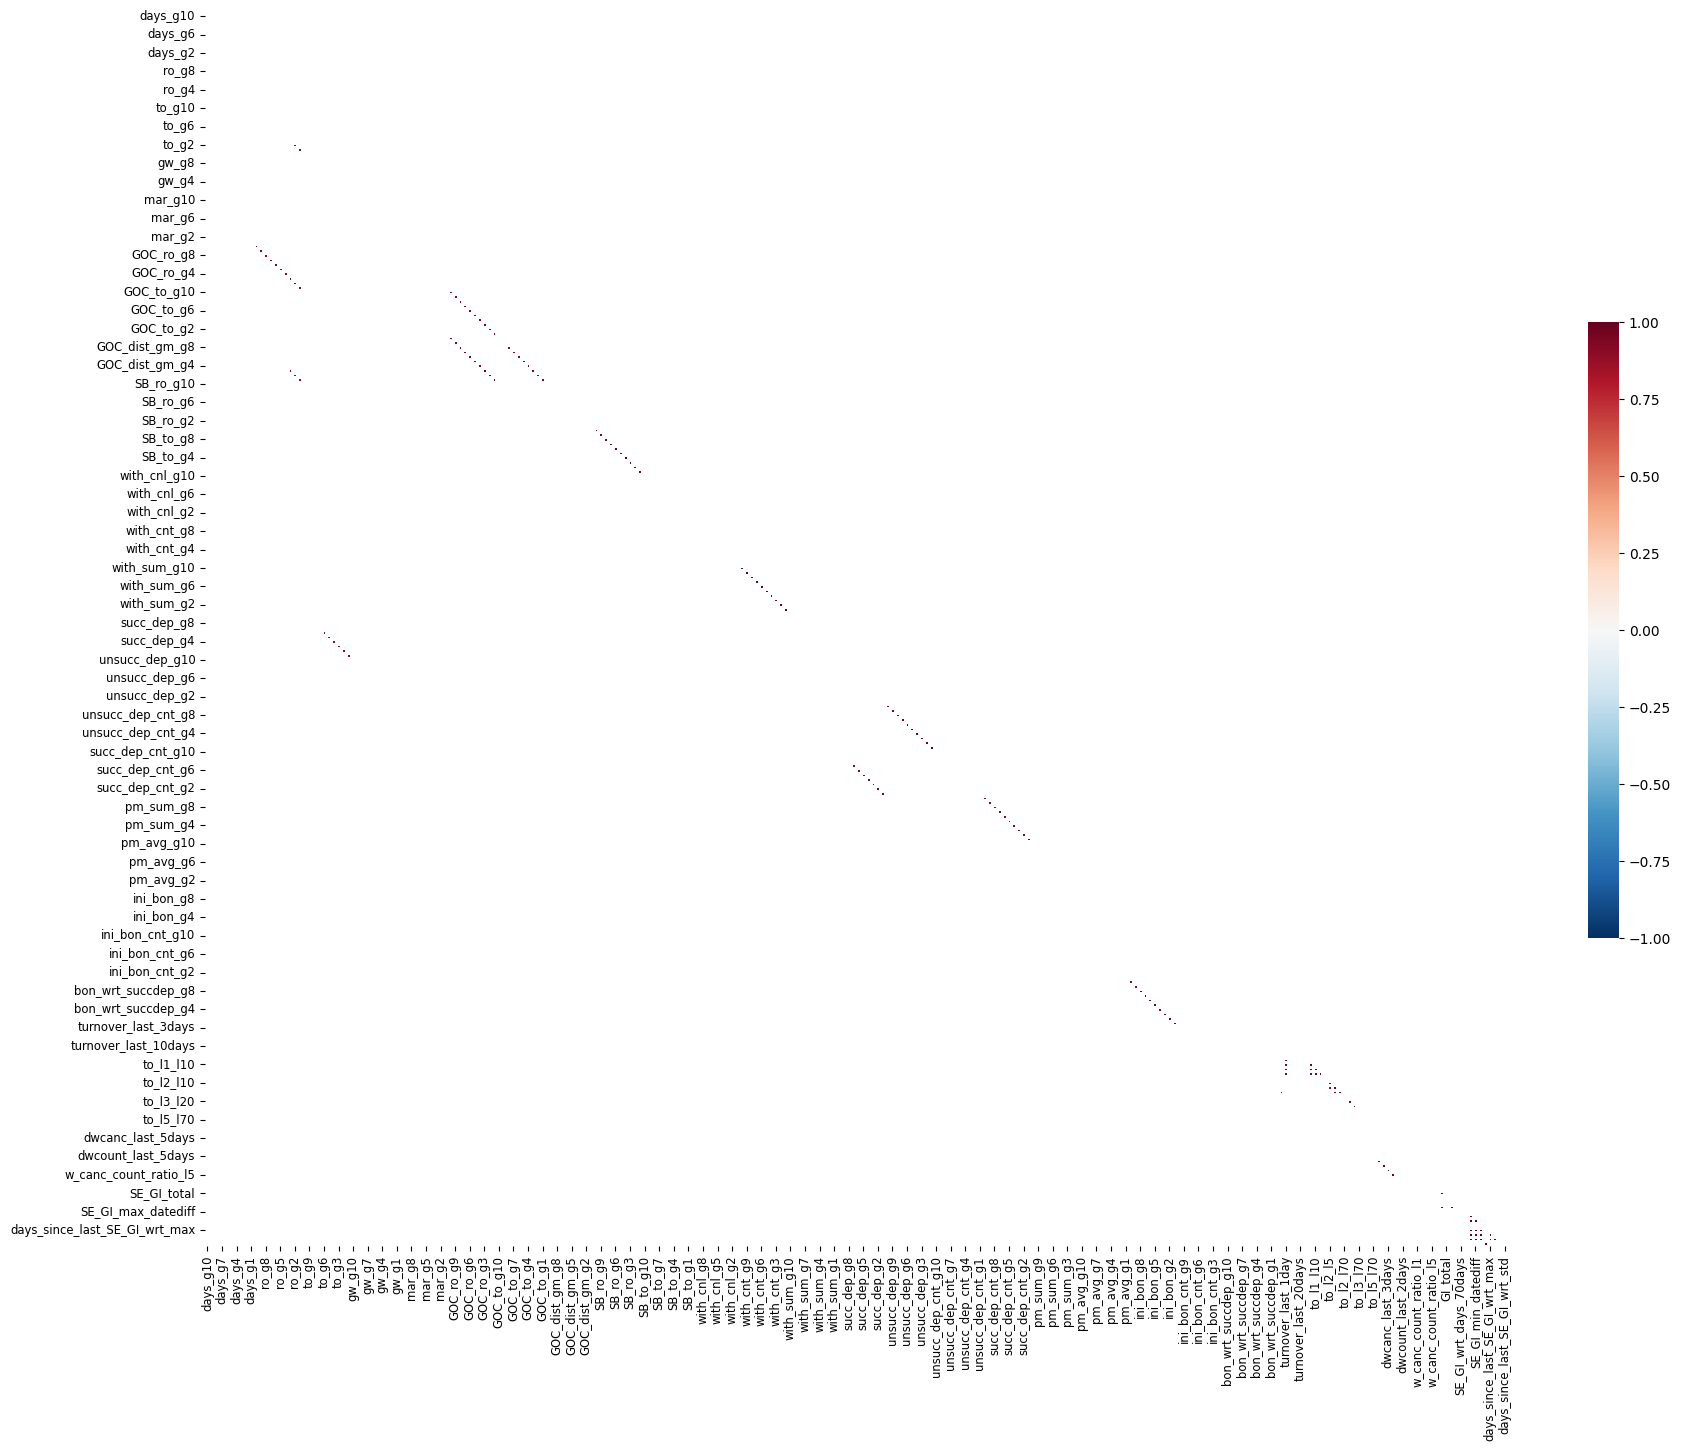

In [272]:
# Correlation
dfc = df.loc[:,'days_g10':'days_since_last_SE_GI_wrt_std'].corr(method='spearman')

# Plot
plt.figure(figsize=(21,16))

mask = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

# Show only significant correlations given target threshold
mask = mask | (dfc.abs() < 0.9).values

ax = sns.heatmap(
    dfc, cmap='RdBu_r', mask=mask, square=False, center=0, vmin=-1, vmax=1, linewidths=1,
    annot=False, fmt=".2f", annot_kws={"fontsize":"small"},
    cbar=True, cbar_kws={'orientation':'vertical', 'shrink': .5}
)

# ax.set_xticks(np.arange(dfc.shape[1]) + 0.5, minor=False)
# ax.set_yticks(np.arange(dfc.shape[0]) + 0.5, minor=False)

# ax.set_xticklabels(ax.get_xticklabels())
# ax.tick_params(axis='both', which='both', labelsize=8)

plt.xticks(fontsize='small')
plt.yticks(fontsize='small') 

plt.show()

In [242]:
df.columns

Index(['ScoreDate', 'days_g10', 'days_g9', 'days_g8', 'days_g7', 'days_g6',
       'days_g5', 'days_g4', 'days_g3', 'days_g2',
       ...
       'days_since_last_SE_GI', 'SE_GI_max_datediff', 'SE_GI_min_datediff',
       'SE_GI_avg_datediff', 'SE_GI_std_datediff',
       'days_since_last_SE_GI_wrt_max', 'days_since_last_SE_GI_wrt_min',
       'days_since_last_SE_GI_wrt_avg', 'days_since_last_SE_GI_wrt_std',
       'country'],
      dtype='object', length=270)

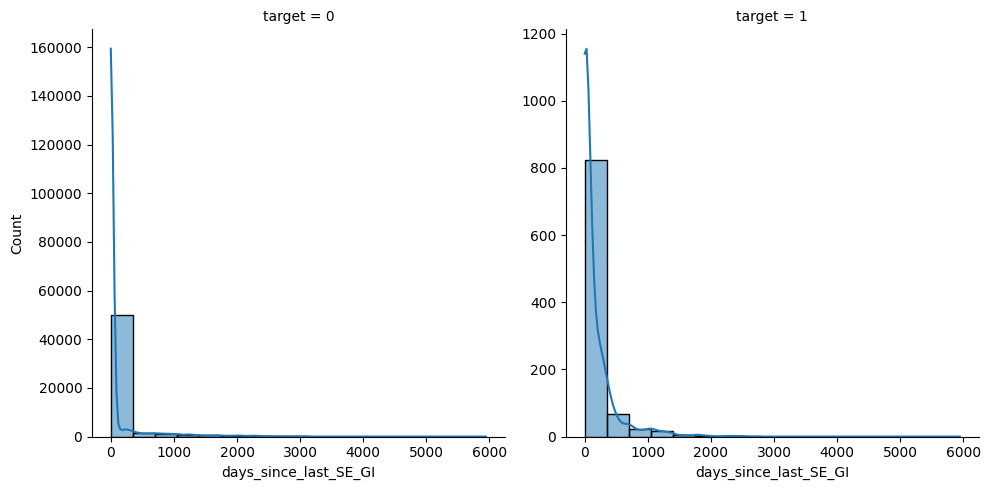

In [260]:
sns.displot(data=df, x='days_since_last_SE_GI', col='target', facet_kws=dict(sharey=False), kde=True)

In [ ]:
a

# Preprocessing

In [103]:
df_model = df.drop(columns=['ScoreDate'])

In [181]:
TARGET = 'target'

NUMERICAL_FEATURES = df_model.drop(columns=TARGET).select_dtypes('number').columns.tolist()
CATEGORICAL_FEATURES = df_model.drop(columns=TARGET).select_dtypes(exclude = 'number').columns.tolist()
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES

In [182]:
X = df_model[FEATURES]
y = df_model[TARGET]

# Modeling

In [196]:
from src.utils import clf_metrics

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [262]:
pca = PCA(n_components=.99)
pca.fit(X[NUMERICAL_FEATURES])

df_pca = pd.DataFrame(
    {
        'var': pca.explained_variance_ratio_,
        'cum_var': pca.explained_variance_ratio_.cumsum()
    },
    index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
)

df_pca

,var,cum_var
PC1,0.690614,0.690614
PC2,0.108923,0.799537
PC3,0.047846,0.847383
PC4,0.031762,0.879146
PC5,0.025847,0.904993
PC6,0.015794,0.920787
PC7,0.015036,0.935822
PC8,0.011565,0.947387
PC9,0.009230,0.956618
PC10,0.008753,0.965371


In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [264]:
# preprocessor = ColumnTransformer([
#     ('num', 'passthrough', NUMERICAL_FEATURES),
#     ('cat', OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES)
# ])

# model_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', RandomForestClassifier(class_weight='balanced'))
# ])

preprocessor = ColumnTransformer([
    ('num', PCA(n_components=.99), NUMERICAL_FEATURES),
    ('cat', OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced'))
])

In [265]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', PCA(n_components=0.99),
                                                  ['days_g10', 'days_g9',
                                                   'days_g8', 'days_g7',
                                                   'days_g6', 'days_g5',
                                                   'days_g4', 'days_g3',
                                                   'days_g2', 'days_g1',
                                                   'ro_g10', 'ro_g9', 'ro_g8',
                                                   'ro_g7', 'ro_g6', 'ro_g5',
                                                   'ro_g4', 'ro_g3', 'ro_g2',
                                                   'ro_g1', 'to_g10', 'to_g9',
                                                   'to_g8', 'to_g7', 'to_g6',
                                                   'to_g5', 'to_g4', 'to_g3',
                                                  

In [266]:
y_pred = model_pipeline.predict(X_test)

In [267]:
clf_metrics(y_test, y_pred)

/home/cmcouto-silva/miniconda3/envs/crm/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.9836686817648651,
 'Balanced Accuracy': 0.5,
 'Recall': 0.0,
 'Precison': 0.0,
 'F1': 0.0}

In [239]:
feature_names = model_pipeline[0].get_feature_names_out()
feature_importances = model_pipeline[1].feature_importances_

AttributeError: Transformer num (type PCA) does not provide get_feature_names_out.

<AxesSubplot:>

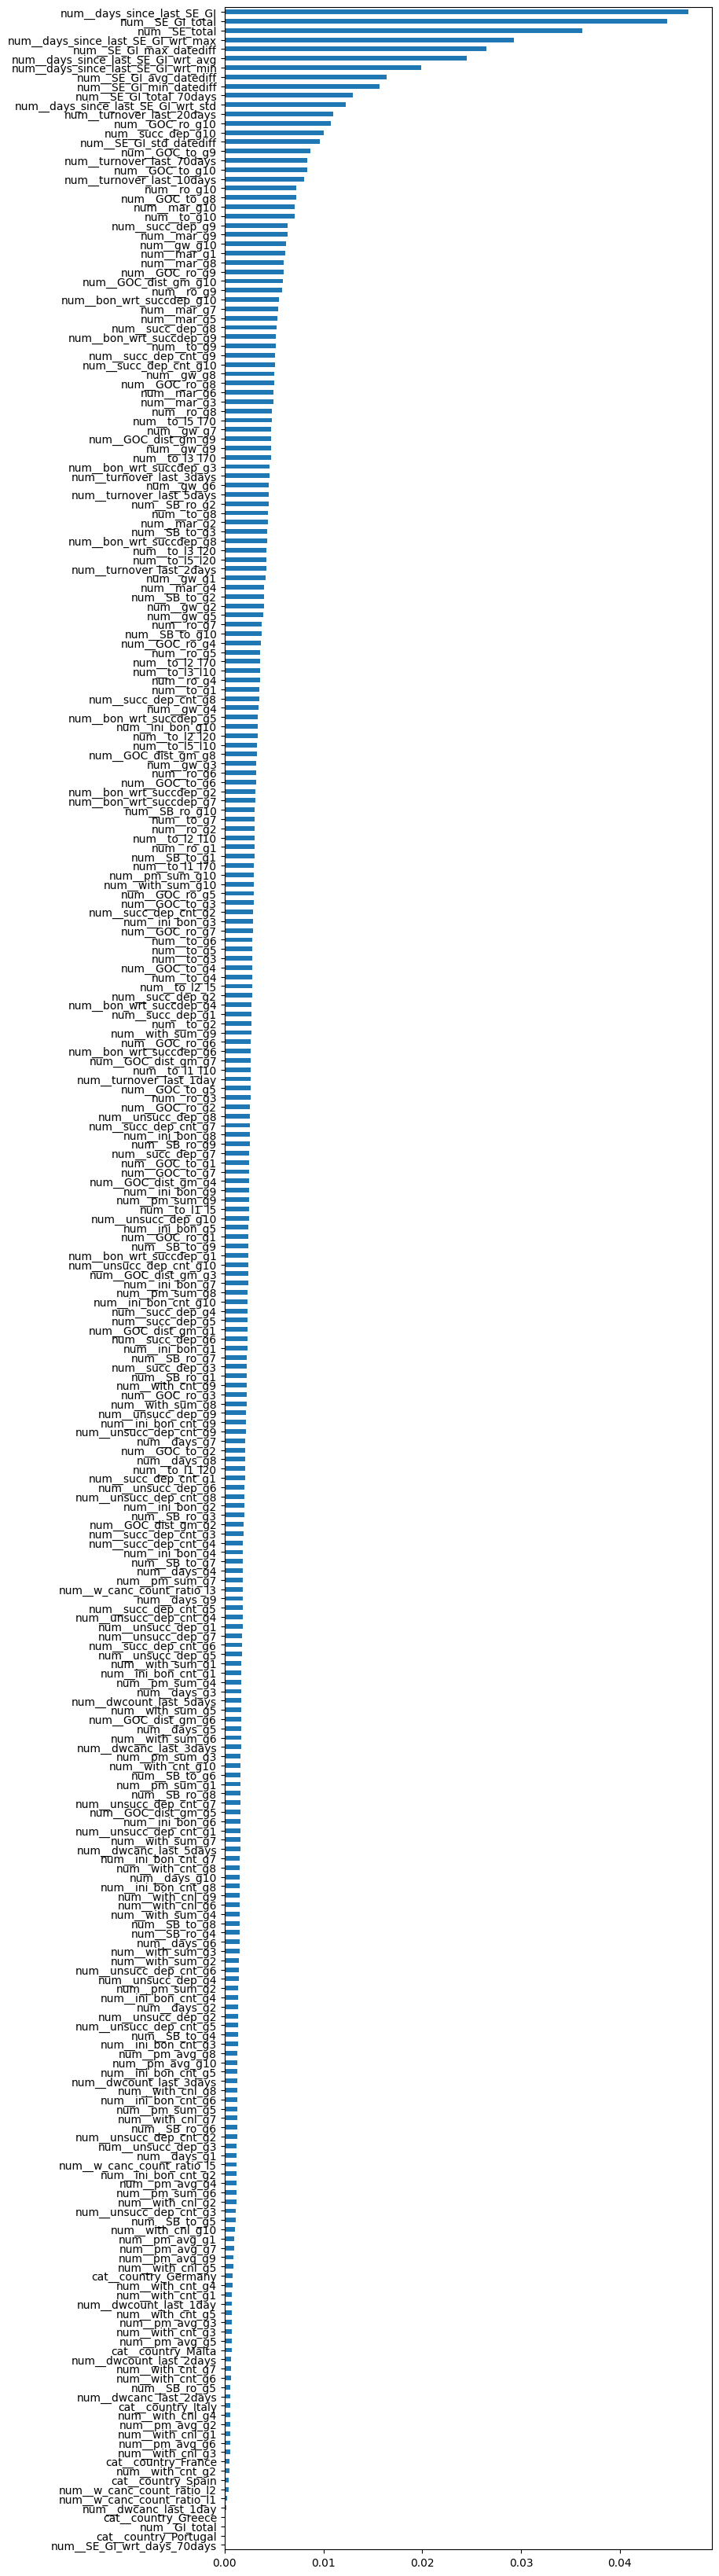

In [240]:
pd.Series(feature_importances, index=feature_names).sort_values().plot.barh(figsize=(8,42))